In [1]:
BAN_ANNOTATORS = [
    "annotator_2@mail.com",
    "annotator_5@mail.com",
    "annotator_6@mail.com",
    "annotator_8@mail.com",
    "annotator_10@mail.com"
]

In [2]:
TRANSLATION_TOPICS = {
    "Rapport qualité-prix": "Value for Money",
    "Ambiance": "Ambience",
    "Chambre": "Room",
    "Emplacement": "Location",
    "Personnel": "Staff"
}

In [3]:
ALIAS_MODEL = {
    "Mistral-Small-3.2-24B-Instruct-2506": "Mistral-3.2-24B",
    "gemma-3-27b-it": "Gemma-3-27B",
    "gemma-3-12b-it": "Gemma-3-12B",
    "Llama-3.1-8B-Instruct": "Llama-3.1-8B",
    "Mistral-Nemo-Instruct-FP8-2407": "Mistral-Nemo-12B",
    "Ministral-8B-Instruct-2410": "Ministral-8B",
    "Llama-3.3-70B-Instruct": "Llama-3.3-70B"
}

In [4]:
import pandas as pd

# Load TSV
df = pd.read_csv("../data/score/mattcoef_prompt.tsv", sep="\t")

# 1. Remove 'keywords-' prefix in 'Model'
df = df[~df['Model'].str.contains('1B|3B|keywords-|Llama-3.3-70B-Instruct-FP8')]



# Melt to long format
df_long = df.melt(
    id_vars=["Model", "annotator_1", "annotator_2", "V"],
    var_name="Topic",
    value_name="MCC"
)

# Optionally filter annotators
df_long['Model'] = df_long['Model'].map(ALIAS_MODEL)

df_long['Topic'] = df_long['Topic'].map(TRANSLATION_TOPICS)

df= df_long



In [5]:
df_ban_corr = df_long[~(df_long["annotator_1"].isin(BAN_ANNOTATORS) & df_long["annotator_2"].isin(BAN_ANNOTATORS))]
df = df_long[~(df_long["annotator_1"].isin(BAN_ANNOTATORS) & df_long["annotator_2"].isin(BAN_ANNOTATORS) & df_long["V"] == "full")]


In [6]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Pivot the DataFrame so that 'sample' and 'full' are columns
df_pivot = df_ban_corr.pivot_table(
    index=["Model", "annotator_1", "annotator_2", "Topic"],
    columns="V",
    values="MCC"
).reset_index()

# Function to compute correlations for a group
def compute_corr(group):
    if group["sample"].notnull().any() and group["full"].notnull().any():
        pearson_corr, _ = pearsonr(group["sample"], group["full"])
        spearman_corr, p_value = spearmanr(group["sample"], group["full"])
    else:
        pearson_corr, spearman_corr = None, None
    return pd.Series({"Pearson": pearson_corr, "Spearman": spearman_corr, "P": p_value})

# Group by Model and Topic
correlations = df_pivot.groupby(["Model", "Topic"]).apply(compute_corr).reset_index()

print(correlations)


               Model            Topic   Pearson  Spearman             P
0        Gemma-3-12B         Ambience  0.918226  0.905294  3.100769e-26
1        Gemma-3-12B         Location  0.991778  0.918731  2.472430e-28
2        Gemma-3-12B             Room  0.978631  0.777367  6.439966e-15
3        Gemma-3-12B            Staff  0.802215  0.775993  7.704114e-15
4        Gemma-3-12B  Value for Money  0.199400  0.208650  8.772532e-02
5        Gemma-3-27B         Ambience  0.953425  0.964156  9.470330e-40
6        Gemma-3-27B         Location  0.882853  0.712099  9.850440e-12
7        Gemma-3-27B             Room  0.640380  0.573577  3.175261e-07
8        Gemma-3-27B            Staff  0.879275  0.864746  2.041092e-21
9        Gemma-3-27B  Value for Money  0.352099  0.349582  3.477000e-03
10      Llama-3.1-8B         Ambience  0.773971  0.732717  1.225408e-12
11      Llama-3.1-8B         Location  0.915876  0.871321  4.395148e-22
12      Llama-3.1-8B             Room  0.294094  0.283697  1.905

/tmp/ipykernel_14747/2008115954.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations = df_pivot.groupby(["Model", "Topic"]).apply(compute_corr).reset_index()


/tmp/ipykernel_14747/1960694847.py:22: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  ax = sns.barplot(
/tmp/ipykernel_14747/1960694847.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topic_stats = correlations.groupby("Topic")["Spearman"].agg(["mean", "std"])


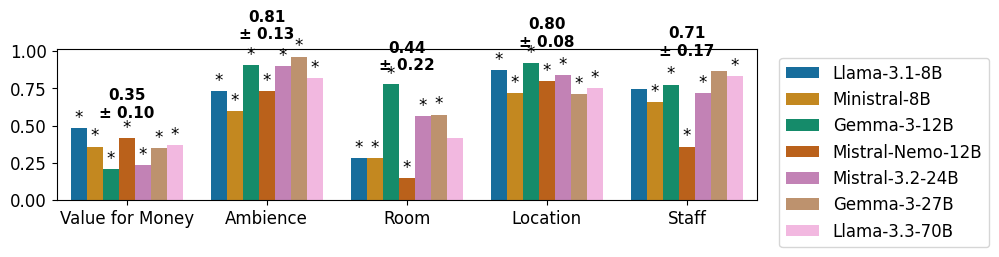

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure Topic order
correlations['Topic'] = pd.Categorical(
    correlations['Topic'],
    categories=['Value for Money','Ambience', 'Staff', 'Room', 'Location'],
    ordered=True
)

# Sort models by size
def extract_size(model_name):
    return int(model_name.split('-')[-1].replace('B',''))

model_order = sorted(correlations['Model'].unique(), key=extract_size)
correlations['Model'] = pd.Categorical(correlations['Model'], categories=model_order, ordered=True)

plt.figure(figsize=(10, 2.5))

# Plot
ax = sns.barplot(
    data=correlations,
    x="Topic",
    y="Spearman",
    hue="Model",
    order=TRANSLATION_TOPICS.values(),
    palette=sns.color_palette("colorblind"),
)

ax = plt.gca()

# Compute mean and std per topic (across all models)
topic_stats = correlations.groupby("Topic")["Spearman"].agg(["mean", "std"])

models = list(correlations['Model'].cat.categories)

num_topics = len(TRANSLATION_TOPICS.values(),)
num_models = len(models)

# Loop through topics
for t_idx, topic in enumerate(TRANSLATION_TOPICS.values(),):

    # Retrieve patches corresponding to this topic across all models
    topic_patches = []
    for m_idx in range(num_models):
        patch_index = m_idx * num_topics + t_idx
        topic_patches.append(ax.patches[patch_index])

    # Midpoint of the topic's grouped bars
    xs = [p.get_x() + p.get_width() / 2 for p in topic_patches]
    mid_x = sum(xs) / len(xs)

    # Maximum bar height in the group
    max_y = max([p.get_height() for p in topic_patches])

    mean_val = topic_stats.loc[topic, "mean"]
    std_val  = topic_stats.loc[topic, "std"]

    # Add text label (mean ± std)
    ax.text(
        mid_x,
        max_y * 1.1,
        f"{mean_val:.2f}\n± {std_val:.2f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )


threshold = 0.05
marker = "*"

for patch, p_val in zip(ax.patches, correlations["P"]):
    if p_val < threshold:
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        ax.text(
            x, y + 0.01, marker,
            ha="center", va="bottom",
            fontsize=12, color="black"
        )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("", fontsize=14)
plt.ylabel("", fontsize=14)

# Legend outside
plt.legend(title="", loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig('corr_intra.png')
plt.show()


In [8]:
df['Topic'] = pd.Categorical(df['Topic'], categories=TRANSLATION_TOPICS.values(), ordered=True)
df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)


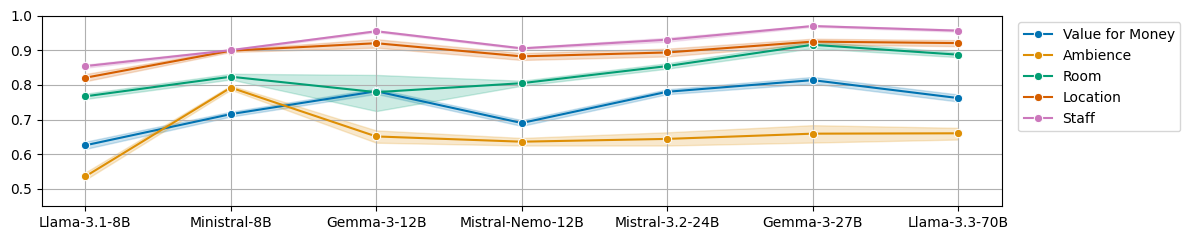

In [9]:
# Line plot of MCC by Topic, colored by Model
plt.figure(figsize=(12,2.5))
sns.lineplot(
    data=df[df['V']=='sample'], 
    x='Model', 
    y='MCC', 
    hue='Topic', 
    marker='o', 
    hue_order=TRANSLATION_TOPICS.values(), 
    palette="colorblind"
)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylim(0.45,1)
plt.grid(True)

# Move legend outside
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.savefig('intra_mcc_base.png', bbox_inches='tight')
plt.show()


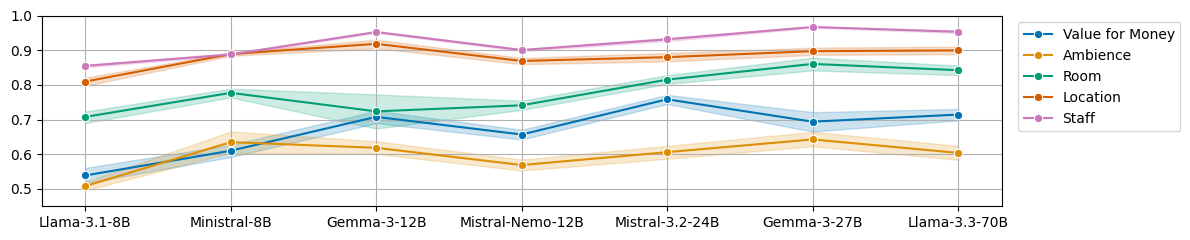

In [11]:
# Line plot of MCC by Topic, colored by Model
plt.figure(figsize=(12,2.5))
sns.lineplot(
    data=df[df['V']=='full'], 
    x='Model', 
    y='MCC', 
    hue='Topic', 
    marker='o', 
    hue_order=TRANSLATION_TOPICS.values(), 
    palette="colorblind"
)
plt.ylabel('')
plt.xlabel('')
plt.xticks(rotation=0)
plt.ylim(0.45,1)
plt.grid(True)

# Move legend outside
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.savefig('intra_mcc_extend.png', bbox_inches='tight')
plt.show()
